# References
- https://www.tensorflow.org/recommenders/examples/basic_retrieval
- https://www.tensorflow.org/recommenders/examples/basic_ranking

# Initial Imports

In [1]:
!pip install -q tensorflow-recommenders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf

import tensorflow_recommenders as tfrs

# Loading Data

In [103]:
key='9aadb790'
user_count=1000
generate_count=1000
event_count=400

ratings_df = pd.read_csv(f"https://my.api.mockaroo.com/rating.json?key={key}&count={generate_count}&user_id={user_count}&event_id={event_count}")

# drop duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        ratings_df.drop(index=row, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

# check for duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        print(row)


ratings_df.to_csv('ratings.csv', sep=',', encoding='utf-8')
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

In [104]:
events_df = pd.read_csv("events.csv")

non_numeric_cols = events_df.select_dtypes(exclude=['int64', 'float64', 'string']).columns
events_df[non_numeric_cols] = events_df[non_numeric_cols].astype(str)
events_df['interested'] = events_df['interested'].fillna(0).astype(int)

events = tf.data.Dataset.from_tensor_slices(dict(events_df))

## ID as str

In [5]:
ratings_df = pd.read_csv(f"https://api.mockaroo.com/api/9ba52b20?count=1000&key=9aadb790&user_id=1000&event_id={event_count}")
events_df = pd.read_csv("./events.csv")
ratings_df[['event_id','user_id']] = ratings_df[['event_id','user_id']].astype(str)
events_df = events_df.astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))
events = tf.data.Dataset.from_tensor_slices(dict(events_df))

In [105]:
print(ratings_df.info(verbose=True))
print(events_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      996 non-null    int64
 1   user_rating  996 non-null    int64
 2   event_id     996 non-null    int64
dtypes: int64(3)
memory usage: 23.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           400 non-null    int64 
 1   date         400 non-null    object
 2   event_name   400 non-null    object
 3   location     400 non-null    object
 4   description  400 non-null    object
 5   tags         400 non-null    object
 6   interested   400 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 20.4+ KB
None


In [106]:
ratings_df.head(3)

,user_id,user_rating,event_id
0,100,4,316
1,718,5,111
2,776,1,289


In [107]:
events_df.head(3)

,id,date,event_name,location,description,tags,interested
0,1,"Wed, 24 - Fri, 26 May 2023",Tyre & Rubber Indonesia,Jakarta,The Tyre & Rubber Indonesia is the only dedica...,"['Tradeshow', 'Auto & Automotive', 'Rubber & T...",304
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine – GET your ultimate business chances ...,"['Tradeshow', 'Building & Construction']",102
2,3,"Sun, 11 - Wed, 14 Jun 2023",ICM Triennial Congress,Bali,It will be six years since our last in-person ...,"['Conference', 'Medical & Pharma', 'Investment']",35


In [108]:
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df)).map(lambda x: {
    "event_id": x["event_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})
events = tf.data.Dataset.from_tensor_slices(dict(events_df)).map(lambda x: x["id"])

In [109]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
n = tf.data.experimental.cardinality(shuffled)

train = shuffled.take(int(n*4/5))
test = shuffled.skip(int(n*4/5)).take(int(n*1/5))

In [110]:
event_names = events.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_event_ids = np.unique(np.concatenate(list(event_names)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Creating Models

## Retrieval Model

In [111]:
embedding_dimension = 32
# Add an additional embedding to account for unknown tokens.
# Candidate tower
event_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(vocabulary=unique_event_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_event_ids) + 1, embedding_dimension)
])

# Query tower
user_model = tf.keras.Sequential([
    tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

class RetrievalModel(tfrs.Model):

  def __init__(self):
    super().__init__()
    self.event_model: tf.keras.Model = event_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
      metrics = tfrs.metrics.FactorizedTopK(
        candidates=events.batch(128).map(event_model)
        ))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    positive_event_embeddings = self.event_model(features["event_id"])

    # parameter: query embedding, candidate embedding.
    return self.task(user_embeddings, positive_event_embeddings)

## Ranking Model

In [112]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    self.user_embeddings = user_model
    self.event_embeddings = event_model

    self.ratings = tf.keras.Sequential([
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):
    user_id, event_id = inputs

    user_embedding = self.user_embeddings(user_id)
    event_embedding = self.event_embeddings(event_id)

    # given user and event, predict rating that the user would give to the event
    return self.ratings(tf.concat([user_embedding, event_embedding], axis=1))

class EventModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  # Call what model to use when making prediction
  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["event_id"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [113]:
# user id + event id = predicted rating
user_ids, event_ids = np.array([99 for i in range(1000)]), np.array([i for i in range(1,1001)])
predicted_list = list(np.concatenate(RankingModel()((user_ids, event_ids)).numpy()))
predicted_event_id = predicted_list.index(max(predicted_list))
print(f'predicted event id: {predicted_event_id}')
print(f'highest score: {max(predicted_list)}')

predicted event id: 183
highest score: 0.01854078099131584


# Model Fitting, Evaluating, Predicting

## Retrieval Model

### Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [114]:
retrieval_model = RetrievalModel()
retrieval_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

retrieval_model.fit(cached_train, epochs=1)

1/1 [==============================] - 1s 567ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0063 - factorized_top_k/top_10_categorical_accuracy: 0.0163 - factorized_top_k/top_50_categorical_accuracy: 0.1068 - factorized_top_k/top_100_categorical_accuracy: 0.2349 - loss: 5316.9365 - regularization_loss: 0.0000e+00 - total_loss: 5316.9365


In [115]:
retrieval_model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 295ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0101 - factorized_top_k/top_10_categorical_accuracy: 0.0352 - factorized_top_k/top_50_categorical_accuracy: 0.1407 - factorized_top_k/top_100_categorical_accuracy: 0.2462 - loss: 1053.3262 - regularization_loss: 0.0000e+00 - total_loss: 1053.3262


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.01005025114864111,
 'factorized_top_k/top_10_categorical_accuracy': 0.035175878554582596,
 'factorized_top_k/top_50_categorical_accuracy': 0.14070351421833038,
 'factorized_top_k/top_100_categorical_accuracy': 0.24623115360736847,
 'loss': 1053.326171875,
 'regularization_loss': 0,
 'total_loss': 1053.326171875}

Why test performance is bad:
- The model is re-recommending some events that the users' already rated. These can crowd out test movies out of top K recommendations.
    - In some cases, re-recommending past things is good.

### Making predictions

Now that we have a retrieval_model, we would like to be able to make predictions. We can use the `tfrs.layers.factorized_top_k.BruteForce` layer to do this.

In [132]:
import random
user_id = random.choice(ratings_df['user_id'])
ratings_df.loc[ratings_df['user_id']==user_id]

,user_id,user_rating,event_id
24,916,5,80
622,916,5,91
928,916,4,39


In [133]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model, k=100)
# recommends events out of the entire events dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((events.batch(100), events.batch(100).map(retrieval_model.event_model)))
)

# Get k recommendations. INPUT MUST HAVE AT LEAST K ITEMS
i, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {[int(i) for i in titles[0, :]]}")

Recommendations for user 916: [80, 193, 178, 375, 40, 335, 259, 205, 314, 73, 76, 260, 304, 36, 48, 238, 213, 208, 184, 399, 279, 28, 188, 118, 121, 290, 281, 3, 244, 267, 152, 261, 231, 100, 296, 250, 329, 319, 298, 370, 356, 371, 74, 35, 318, 269, 112, 130, 120, 187, 284, 256, 395, 68, 104, 202, 128, 252, 365, 366, 4, 146, 45, 182, 191, 195, 253, 292, 374, 89, 336, 185, 143, 132, 339, 165, 155, 7, 302, 367, 119, 30, 78, 39, 294, 105, 203, 358, 19, 2, 159, 255, 248, 236, 382, 149, 361, 37, 61, 156]


In [75]:
events_df.loc[events_df['id'].isin([i for i in titles[0,:].numpy()])]

,id,date,event_name,location,description,type,interested
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine – GET your ultimate business chances ...,"['Tradeshow', 'Building & Construction']",102
14,15,"Wed, 24 - Thu, 25 May 2023",SEO Conference (SEOCon),Jakarta,"SEO Conference, search Engines have become an ...","['Conference', 'Business Services']",22
51,52,"Thu, 29 - Fri, 30 Jun 2023","International Conference on Language, Literatu...",Jakarta,nan,"['Conference', 'Education & Training']",8
86,87,"Thu, 07 - Sat, 09 Sep 2023",Bali Hotel Supplies Expo\n,Bali,nan,"['Tradeshow', 'Food & Beverages', 'Hotel, Rest...",71
129,130,"Mon, 29 - Tue, 30 May 2023","International Conference on Electronics, Artif...",Surabaya,nan,"['Conference', 'Electric & Electronics', 'IT &...",22
203,204,"Wed, 18 - Fri, 20 Oct 2023",Pacific Coatings Show\n,Jakarta,The International World Of Paint & Coatings,"['Tradeshow', 'Auto & Automotive', 'Industrial...",1
247,248,"Fri, 23 - Sat, 24 Feb 2024","International Conference on Computer, Cybernet...",Pasar Minggu,"International Conference On Computer , Cyberne...","['Conference', 'Education & Training', 'IT & T...",5
298,299,"Fri, 04 - Sun, 06 Aug 2023",Halal Fair Jakarta\n,Jakarta,Halal Fair Series is the annual consumer and t...,"['Tradeshow', 'Travel & Tourism', 'Food & Beve...",0
340,341,"Mon, 09 Oct 2023",IFN Indonesia Dialogues\n,Jakarta,nan,"['Conference', 'Banking & Finance']",0
368,369,"Sat, 18 Nov 2023",Begin Offline Private and Boarding School Fair...,Jakarta,nan,"['Tradeshow', 'Education & Training', 'Enterta...",0


## Ranking Model

In [76]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

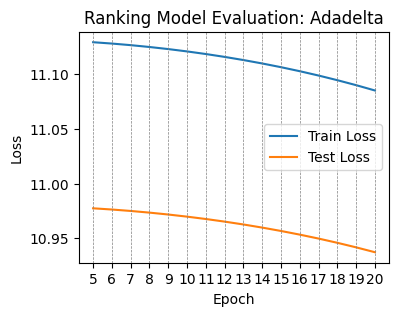

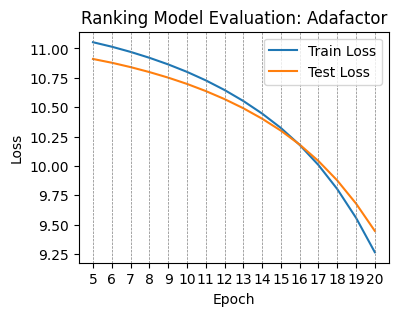

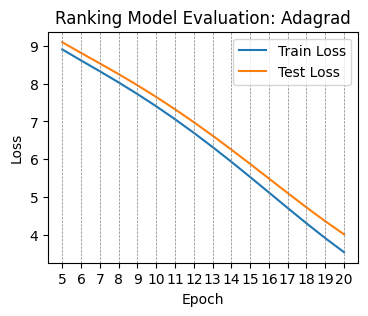

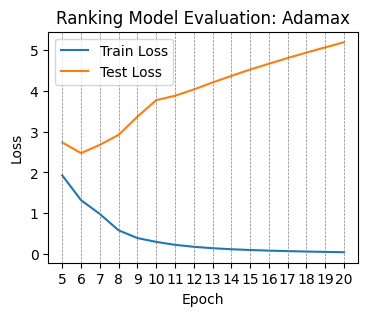

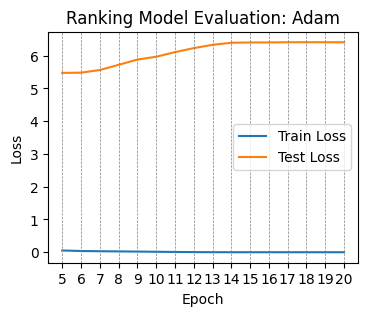

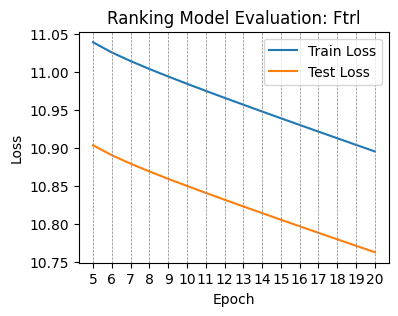

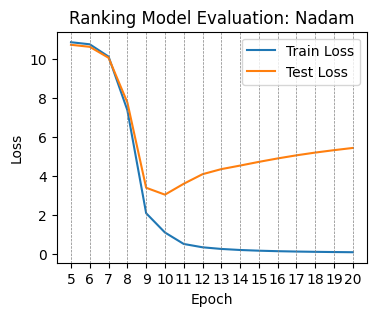

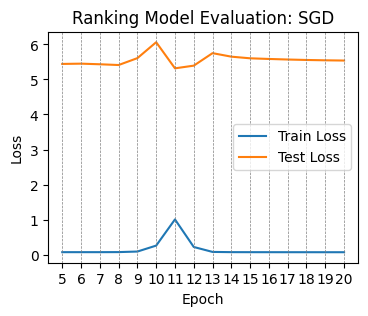

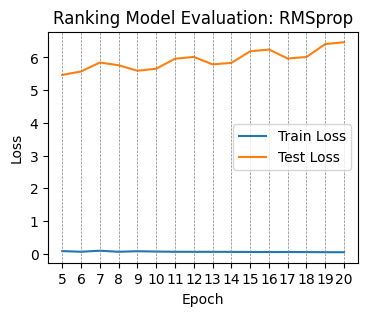

In [77]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adadelta(),
        tf.keras.optimizers.Adafactor(),
        tf.keras.optimizers.Adagrad(),
        tf.keras.optimizers.Adamax(),
        tf.keras.optimizers.Adam(),
        tf.keras.optimizers.Ftrl(),
        tf.keras.optimizers.Nadam(),
        tf.keras.optimizers.SGD(),
        tf.keras.optimizers.RMSprop(),
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(4,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 5  # Specify the minimum epoch
max_epoch = 20  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


### Choose fitting epoch number

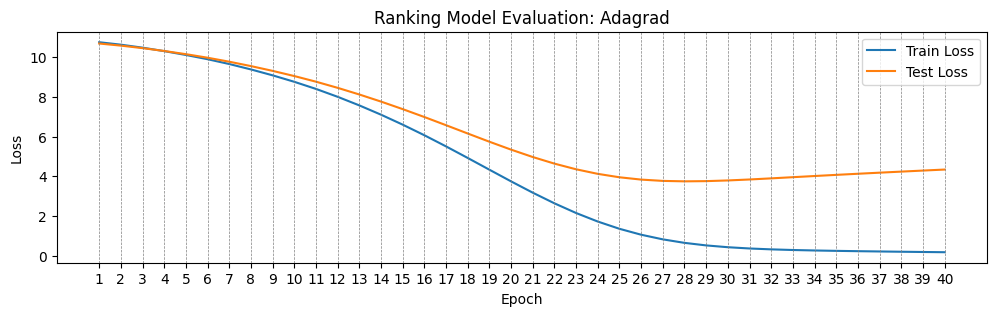

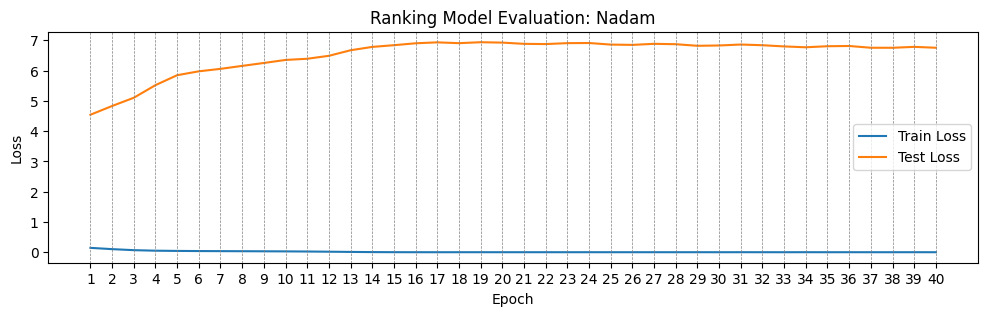

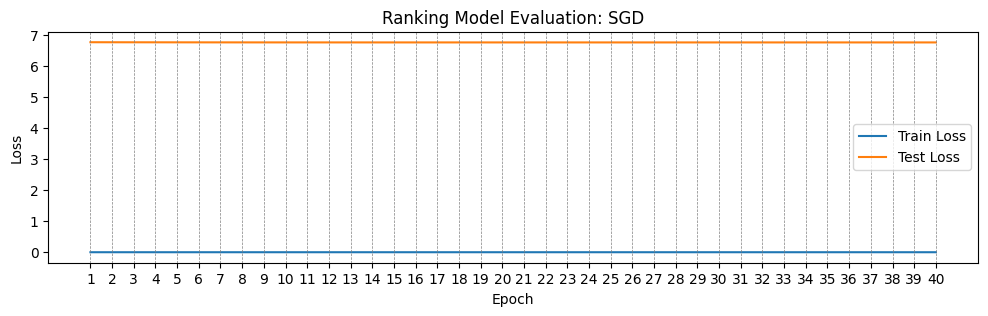

In [78]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.Adagrad(),
        tf.keras.optimizers.Nadam(),
        tf.keras.optimizers.SGD()
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 40  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


### Choose learning rate

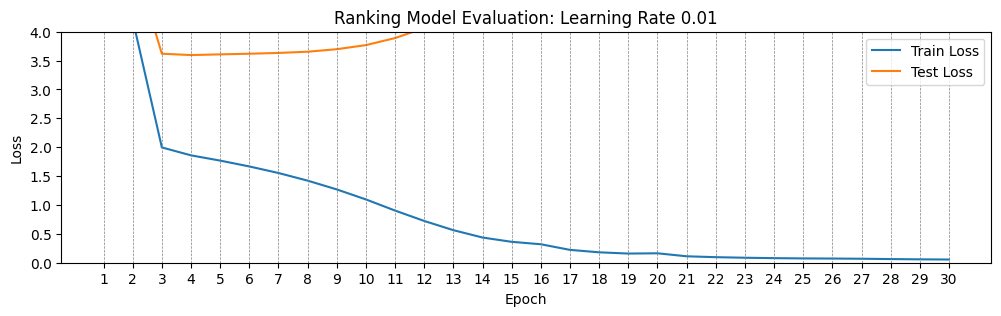

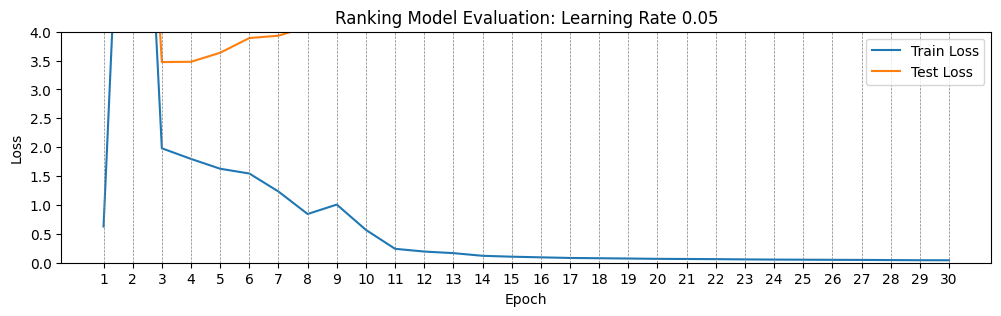

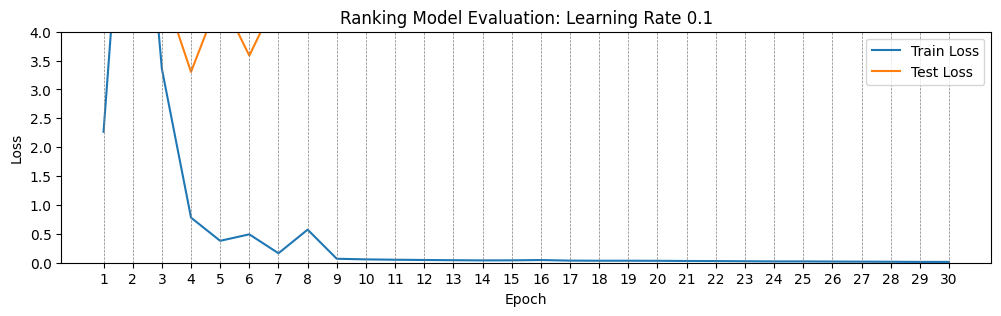

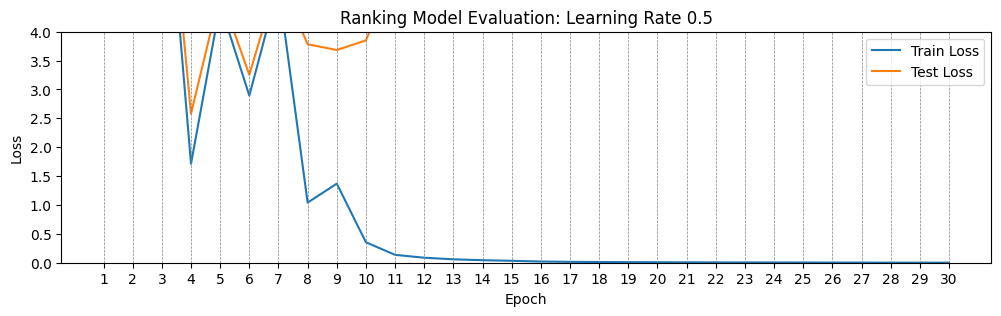

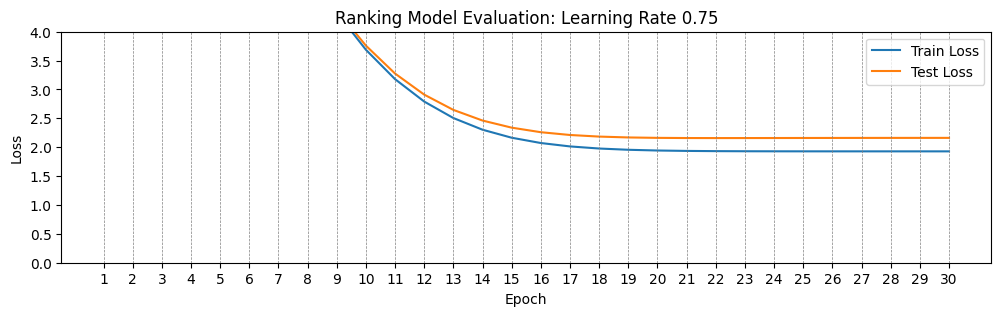

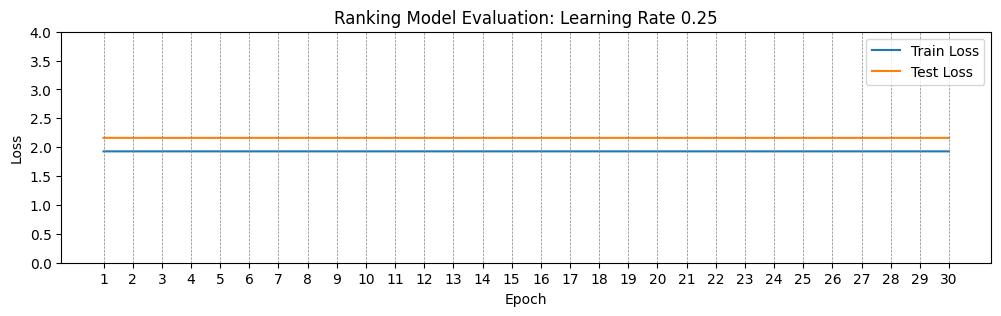

In [84]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    learning_rates = [0.01,0.05,0.1,0.5,0.75,0.25]
    for learning_rate in learning_rates:
        train_losses = []
        test_losses = []
        model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: Learning Rate {learning_rate}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.ylim(bottom=0, top=4)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 30  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


# Choose Epoch for chosen learning rate

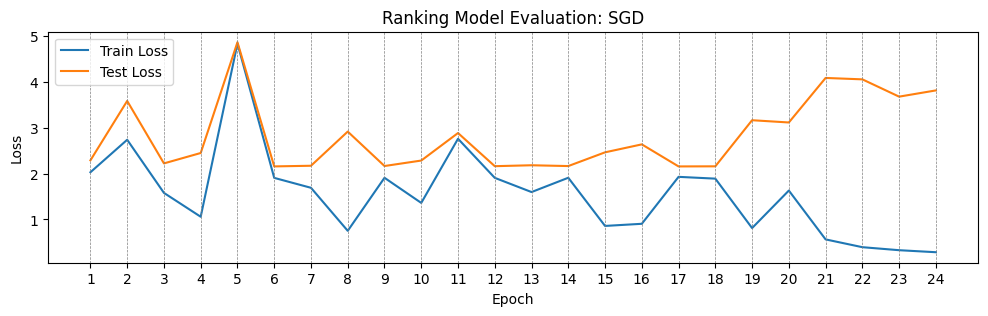

In [96]:
import matplotlib.pyplot as plt

ranking_model = EventModel()

def evaluate_model(model, train_data, test_data, min_epoch, max_epoch):
    epochs = range(min_epoch, max_epoch+1)
    optimizers = [
        tf.keras.optimizers.SGD(learning_rate=0.25)
    ]
    for optimizer in optimizers:
        train_losses = []
        test_losses = []
        model.compile(optimizer=optimizer)

        for epoch in epochs:
            model.fit(train_data, epochs=epoch, verbose=0)
            train_loss = model.evaluate(train_data, verbose=0, return_dict=True)['loss']
            test_loss = model.evaluate(test_data, verbose=0, return_dict=True)['loss']
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        plt.figure(figsize=(12,3))
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Ranking Model Evaluation: {optimizer.name}')
        plt.legend()
        for epoch in epochs:
            plt.axvline(x=epoch, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(ticks=epochs)
        plt.show()
        model.reset_states()

# Assuming you have initialized 'ranking_model', 'cached_train', and 'cached_test' variables

min_epoch = 1  # Specify the minimum epoch
max_epoch = 24  # Specify the maximum epoch

evaluate_model(ranking_model, cached_train, cached_test, min_epoch, max_epoch)


In [97]:
for _ in range(10):
    ranking_model = EventModel()
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.25))
    ranking_model.fit(cached_train, epochs=4, verbose=0)
    print(ranking_model.evaluate(cached_test, return_dict=True))

1/1 [==============================] - 0s 72ms/step - root_mean_squared_error: 2.9195 - loss: 8.5233 - regularization_loss: 0.0000e+00 - total_loss: 8.5233
{'root_mean_squared_error': 2.919464349746704, 'loss': 8.523271560668945, 'regularization_loss': 0, 'total_loss': 8.523271560668945}
1/1 [==============================] - 0s 72ms/step - root_mean_squared_error: 2.6107 - loss: 6.8157 - regularization_loss: 0.0000e+00 - total_loss: 6.8157
{'root_mean_squared_error': 2.610691785812378, 'loss': 6.815711498260498, 'regularization_loss': 0, 'total_loss': 6.815711498260498}
1/1 [==============================] - 0s 71ms/step - root_mean_squared_error: 2.8603 - loss: 8.1814 - regularization_loss: 0.0000e+00 - total_loss: 8.1814
{'root_mean_squared_error': 2.8603172302246094, 'loss': 8.181414604187012, 'regularization_loss': 0, 'total_loss': 8.181414604187012}
1/1 [==============================] - 0s 75ms/step - root_mean_squared_error: 2.8207 - loss: 7.9563 - regularization_loss: 0.0000e+

# Finalize model

In [98]:
ranking_model = EventModel()
ranking_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.05))
ranking_model.fit(cached_train, epochs=4, verbose=0)

In [99]:
import itertools

test_ratings = {}
test_event_ids = [i for i in range(1,event_count+1)]
for event_id in test_event_ids:
  test_ratings[event_id] = ranking_model({
      "user_id": np.array([1]),
      "event_id": np.array([event_id])
  })

print("Ratings Desc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1], reverse=True),10):
  title = events_df.loc[events_df['id']==id, 'event_name'].values[0]
  print(f"{title}: {score[0][0]}")

print()

print("Ratings Asc:")
for id, score in itertools.islice(sorted(test_ratings.items(), key=lambda x: x[1]),10):
  title = events_df.loc[events_df['id']==id, 'event_name'].values[0]
  print(f"{title}: {score[0][0]}")

Ratings Desc:
International Conference on Computer Science, Machine Learning and Big Data (ICCSMLBD)
: 2.9685378074645996
I stop
: 2.9685378074645996
Asia Expo Jakarta
: 2.9685378074645996
Mergers & Acquisitions Masterclass (M&A)
: 2.9685378074645996
International Conference on Sports Nutrition and Supplements (ICSNS)
: 2.9685378074645996
Project Finance Modeling (PFM)
: 2.9685378074645996
International Conference on Electrical Engineering and Informatics (ICEEI)
: 2.9685378074645996
International Conference on Science in Information Technology (ICSITech)
: 2.9685378074645996
International Conference on Law Reform (INCLAR)
: 2.9629030227661133
Begin Offline Edu Fair. Jakarta, 18 November
: 2.9629030227661133

Ratings Asc:
International Conference on Teaching Education & Learning (ICTEL): 2.2437658309936523
Indonesia International Construction, Infrastructure & Mining Exhibition (CON-MINE): 2.245375156402588
International Conference on Computer Science, Machine Learning and Big Data (IC

# Model Serving

## Retrieval Model

After the model is trained, we need a way to deploy it.

In a two-tower retrieval model, serving has two components:

- a serving query model, taking in features of the query and transforming them into a query embedding, and
- a serving candidate model. This most often takes the form of an approximate nearest neighbours (ANN) index which allows fast approximate lookup of candidates in response to a query produced by the query model.

In [100]:
# path = os.path.join(tmp, "model")
path = "./retrieval_model"

# Save the index.
tf.saved_model.save(index, path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted event titles back.
scores, titles = loaded([42])

scores, titles

INFO:tensorflow:Assets written to: ./retrieval_model\assets


INFO:tensorflow:Assets written to: ./retrieval_model\assets


(<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[0.05251678, 0.05000738, 0.04396329, 0.0420546 , 0.03916779,
         0.03915393, 0.03865249, 0.0365618 , 0.03631911, 0.03583086]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[295, 129, 358, 314, 113, 290, 206, 336, 215, 212]], dtype=int64)>)

## Ranking Model

In [101]:
import itertools

path = "./ranking_model"
# tf.saved_model.save(ranking_model, path)
loaded = tf.saved_model.load(path)

test_ratings = {}
test_event_ids = [i for i in range(1,event_count+1)]
for event_id in test_event_ids:
    test_ratings[event_id] = loaded(
        {'user_id':tf.constant([42], dtype=tf.int64),
        'event_id':tf.constant([event_id], dtype=tf.int64)}
    )
test_ratings # index: score

{1: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9946582]], dtype=float32)>,
 2: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8427517]], dtype=float32)>,
 3: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.2084713]], dtype=float32)>,
 4: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.139973]], dtype=float32)>,
 5: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.88185483]], dtype=float32)>,
 6: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[4.080362]], dtype=float32)>,
 7: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.1854641]], dtype=float32)>,
 8: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.3422266]], dtype=float32)>,
 9: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.76391053]], dtype=float32)>,
 10: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7943623]], dtype=float32)>,
 11: <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.1408614]], dtype=float32)>,
 12: <tf.Tensor: sh